In [1]:
# 모듈 로딩
import glob
import os
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary

[1] Data

In [2]:
files = glob.glob('../data/train/*.txt')
X_train = []
y_train = []
for file_name in files:
    basename = os.path.basename(file_name)
    lang = basename.split('-')[0]

    with open(file_name, mode='r', encoding='utf-8') as f:
        text = f.read()
        text = text.lower()

    code_a = ord('a')
    code_z = ord('z')

    count = [0 for n in range(0, 26)]

    for character in text:
        code_current = ord(character)

        if code_a <= code_current <= code_z:
            count[code_current - code_a] += 1

    total = sum(count)
    count = list(map(lambda x:x / total, count))

    X_train.append(count)
    y_train.append(lang)

In [3]:
X_train = pd.DataFrame(X_train, columns=[chr(i) for i in range(97, 123)])

In [4]:
X_train

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z


In [5]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [6]:
y_train = le.transform(y_train)

In [7]:
y_train = pd.DataFrame(y_train)

In [8]:
y_train

,0


In [9]:
files = glob.glob('../data//test/*.txt')
X_test = []
y_test = []
for file_name in files:
    basename = os.path.basename(file_name)
    lang = basename.split('-')[0]

    with open(file_name, mode='r', encoding='utf-8') as f:
        text = f.read()
        text = text.lower()

    code_a = ord('a')
    code_z = ord('z')

    count = [0 for n in range(0, 26)]

    for character in text:
        code_current = ord(character)

        if code_a <= code_current <= code_z:
            count[code_current - code_a] += 1

    total = sum(count)
    count = list(map(lambda x:x / total, count))

    X_test.append(count)
    y_test.append(lang)

In [10]:
X_test = pd.DataFrame(X_test, columns=[chr(i) for i in range(97, 123)])

In [11]:
X_test

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z


In [12]:
y_test = le.transform(y_test)

In [13]:
y_test = pd.DataFrame(y_test)

In [14]:
y_test

,0


[2] Model

In [15]:
class alphaMCFModel(nn.Module):


    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(26, 10)
        self.hidden_layer1 = nn.Linear(10, 30)
        self.hidden_layer2 = nn.Linear(30, 10)
        self.out_layer = nn.Linear(10, 4)



    def forward(self, x):
        y = F.relu(self.in_layer(x))
        y = F.relu(self.hidden_layer1(y))
        y = F.relu(self.hidden_layer2(y))

        return self.out_layer(y)


In [16]:
model = alphaMCFModel()
print(model)

alphaMCFModel(
  (in_layer): Linear(in_features=26, out_features=10, bias=True)
  (hidden_layer1): Linear(in_features=10, out_features=30, bias=True)
  (hidden_layer2): Linear(in_features=30, out_features=10, bias=True)
  (out_layer): Linear(in_features=10, out_features=4, bias=True)
)


In [17]:
summary(model, input_size=(1000,26))

Layer (type:depth-idx)                   Output Shape              Param #
alphaMCFModel                            [1000, 4]                 --
├─Linear: 1-1                            [1000, 10]                270
├─Linear: 1-2                            [1000, 30]                330
├─Linear: 1-3                            [1000, 10]                310
├─Linear: 1-4                            [1000, 4]                 44
Total params: 954
Trainable params: 954
Non-trainable params: 0
Total mult-adds (M): 0.95
Input size (MB): 0.10
Forward/backward pass size (MB): 0.43
Params size (MB): 0.00
Estimated Total Size (MB): 0.54

[3] Dataset

In [18]:
class AlphaDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)

        # 피쳐와 타겟 반환
        return featureTS, targetTS

[4] Learning

In [19]:
EPOCH = 1000
BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

In [20]:
model = alphaMCFModel()

In [21]:
X_train, X_val, y_train, y_val =train_test_split(X_train, y_train, random_state=1)

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
trainDS = AlphaDataset(X_train, y_train)
valDS=AlphaDataset(X_val, y_val)
testDS = AlphaDataset(X_test, y_test)

trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
crossLoss = nn.CrossEntropyLoss()

In [ ]:
SAVE_PATH = '../models/alpha/MCF/'
SAVE_FILE = 'model_train_wbs.pth'
SAVE_MODEL = 'model_all.pth'

In [ ]:
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [ ]:
## 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY=[[],[]], [[],[]]
CNT=len(trainDL)
print(f'BATCH_CNT => {CNT}')

## 학습 모니터링/스케쥴링 설정
# => LOSS_HISTORY, SCORE_HISTORY 활용
# => 임계기준: 10번
BREAK_CNT = 0
LIMIT_VALUE = 10


for epoch in range(EPOCH):
    # 학습 모드로 모델 설정
    model.train()

    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total=0,0
    for featureTS, targetTS in trainDL:
        # 학습 진행
        pre_y=model(featureTS)

        # 손실 계산 : nn.CrossEntropyLoss 요구사항 : 정답/타겟은 0D 또는 1D,  타입은 long
        loss=crossLoss(pre_y, targetTS.reshape(-1).long())
        loss_total += loss.item()

        # 성능평가 계산
        score=MulticlassF1Score(num_classes=4)(pre_y, targetTS.reshape(-1))
        score_total += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featrueTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)

        # 추론/평가
        pre_val=model(val_featrueTS)
        print(pre_val.shape, val_targetTS.reshape(-1).shape)

        # 손실
        loss_val=crossLoss(pre_val, val_targetTS.reshape(-1).long())
        score_val=MulticlassF1Score(num_classes=4)(pre_val, val_targetTS.reshape(-1))

    # 에포크 당 손실값과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT)

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)

    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} SCORE : {SCORE_HISTORY[0][-1]}')
    print(f'- [VALID] LOSS : {LOSS_HISTORY[1][-1]} SCORE : {SCORE_HISTORY[1][-1]}')


    # 학습 진행 모니터링/스케쥴링 - 검증 DS 기준
    # Score 기준
    if len(SCORE_HISTORY[1]) >= 2:
        if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2]: BREAK_CNT += 1

    # 성능이 좋은 학습 가중치 저장
    # SAVE_FILE = f'model_train_wbs_{epoch}_{score_val}.pth'
    if len(SCORE_HISTORY[1]) == 1:
        # 처음 학습 가중치 모델 파라미터 저장
        torch.save(model.state_dict(), SAVE_PATH+SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_PATH+SAVE_MODEL)
    else:
        if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]): # 새로운 값이 최고값일 경우 고려해서 리스트 슬라이싱 [:-1]
            torch.save(model.state_dict(), SAVE_PATH+SAVE_FILE)

    # 학습 중단 여부 설정
    # if BREAK_CNT > LIMIT_VALUE:
    #     print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
    #     break

BATCH_CNT => 2
torch.Size([5, 4]) torch.Size([5])
[0/1000]
- [TRAIN] LOSS : 1.404564619064331 SCORE : 0.12777777947485447
- [VALID] LOSS : 1.379489779472351 SCORE : 0.0833333358168602
torch.Size([5, 4]) torch.Size([5])
[1/1000]
- [TRAIN] LOSS : 1.4027435183525085 SCORE : 0.12777777947485447
- [VALID] LOSS : 1.3793522119522095 SCORE : 0.0833333358168602
torch.Size([5, 4]) torch.Size([5])
[2/1000]
- [TRAIN] LOSS : 1.401352345943451 SCORE : 0.12777777947485447
- [VALID] LOSS : 1.3793855905532837 SCORE : 0.0833333358168602
torch.Size([5, 4]) torch.Size([5])
[3/1000]
- [TRAIN] LOSS : 1.4000366926193237 SCORE : 0.12777777947485447
- [VALID] LOSS : 1.3795166015625 SCORE : 0.0833333358168602
torch.Size([5, 4]) torch.Size([5])
[4/1000]
- [TRAIN] LOSS : 1.3987702131271362 SCORE : 0.12777777947485447
- [VALID] LOSS : 1.3797214031219482 SCORE : 0.0833333358168602
torch.Size([5, 4]) torch.Size([5])
[5/1000]
- [TRAIN] LOSS : 1.3975441455841064 SCORE : 0.12777777947485447
- [VALID] LOSS : 1.379989027

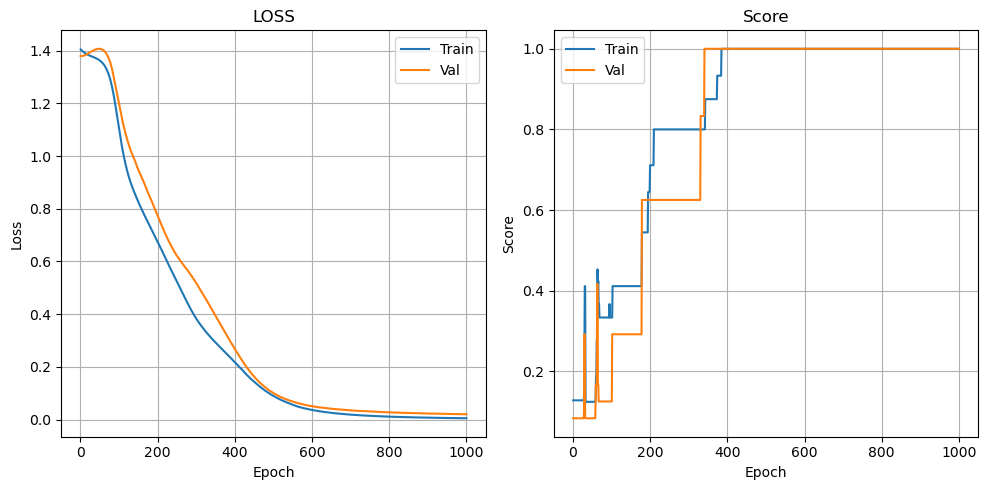

In [ ]:
import matplotlib.pyplot as plt

TH = len(SCORE_HISTORY[1])
fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True)
axes[0].plot(range(1, TH+1), LOSS_HISTORY[0][:TH], label='Train')
axes[0].plot(range(1, TH+1), LOSS_HISTORY[1][:TH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, TH+1), SCORE_HISTORY[0][:TH], label='Train')
axes[1].plot(range(1, TH+1), SCORE_HISTORY[1][:TH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Score")
axes[1].set_title("Score")
plt.tight_layout()
plt.show()